In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import scipy as sp

In [2]:
def generate_reversal_sequence(stable_block_length, volatile_block_length, block_number):
    
    """
    Return a sequence of trials with the correct option reversing in a probabilistic fashion. 
    """

    volatile_size = int(volatile_block_length/block_number) # 'average' volatile block size
    volatile_sequence = np.full( volatile_block_length, 0 )

    # stable block
    cue = np.random.choice([0, 1], p = [0.5, 0.5]) # randomly pick cue that is correct for stable block 
    stable_block = np.full(stable_block_length, cue)    
    
    # generate volatile sequence
    start = 0
    
    for i_reversal in range(block_number-1):

        i = i_reversal + 1
        reversal_point = np.random.randint( i* volatile_size-10, i* volatile_size+10 ) # pick reversal point
        cue = 0 if cue == 1 else 1 # reverse cue
        volatile_sequence[start:reversal_point] = cue # fill the block with the correct cue
        start = reversal_point # shift reversal point
        
    cue = 0 if cue == 1 else 1 
    volatile_sequence[start:volatile_block_length] = cue 

    return stable_block, volatile_sequence

In [3]:
def generate_reward_sequence(cue_sequence, p_reward):
    
    """
    Return a sequence of rewards for the two options based on the sequence of 'correct' options 
    """   
    
    reward_sequence = np.full( (np.size(cue_sequence), 2), 30) # initialising reward sequence

    reward_sequence[np.where(cue_sequence == 1), 1] = np.random.binomial( 1, p_reward, np.size(np.where(cue_sequence == 1)) )
    reward_sequence[np.where(cue_sequence == 1), 0] = 1-reward_sequence[np.where(cue_sequence == 1), 1] 

    reward_sequence[np.where(cue_sequence == 0), 0] = np.random.binomial( 1, p_reward, np.size(np.where(cue_sequence == 0)) )
    reward_sequence[np.where(cue_sequence == 0), 1] = 1-reward_sequence[np.where(cue_sequence == 0), 0] 

    return reward_sequence

In [4]:
# rescorla wagner model

class RescorlaWagner():
    def __init__(self, num_inputs, learning_rate, inv_temperature):
        self.num_inputs = num_inputs
        self.learning_rate = learning_rate
        self.inv_temperature = inv_temperature
        
        self.value = np.full((num_inputs), 0.0)
        
    def choice(self):
        
        Q_ = self.inv_temperature * self.value
        logp_action = Q_ - sp.special.logsumexp(Q_)
        prob_choice = np.exp(logp_action)
        choice = np.random.choice( np.arange(self.num_inputs) , p = prob_choice )
        
        return choice
        
    def learn(self, choice, targets):
        self.value[choice] = self.value[choice] + self.learning_rate * (targets[choice] - self.value[choice]) 
  

In [5]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s
class KalmanFilter():
    
    def __init__(self, num_inputs, inv_temperature, q, q1, q2):
        
        self.num_inputs = num_inputs
        self.reward_variance = q
        self.inv_temperature = inv_temperature        
        self.value = np.zeros((num_inputs, 1))
        self.posterior_variance = np.asarray([[q1],[q2]]) #sigma_rew * np.eye(num_inputs)
        self.alpha = 0
        
    # TODO implement this function
    def choice(self):
        
        Q_ = self.inv_temperature * self.value.flatten()
        logp_action = Q_ - sp.special.logsumexp(Q_)
        prob_choice = np.exp(logp_action)
        choice = np.random.choice( np.arange(self.num_inputs) , p = prob_choice )
        return choice
        
    # TODO implement this function
    def learn(self, choice, targets): 
        posterior_variance=self.posterior_variance
        reward_variance=self.reward_variance
        self.alpha = posterior_variance[choice] / (posterior_variance[choice] + reward_variance)
        moment_match_alpha = np.sqrt(self.posterior_variance[choice]) # moment matching as suggested by Piray (ref from Mackey algorithm)
        self.value[choice] = self.value[choice] + moment_match_alpha * (targets[choice] - sigmoid(self.value[choice]))
        self.posterior_variance[choice] = posterior_variance[choice] - self.alpha * posterior_variance[choice] 

In [6]:
# simulate choices based on Kalman Filter

def predict_KF(N_trials, reward_sequence, inv_temperature, sigma_rew, sigma_1, sigma_2):

    performance_run = []
    
    prediction = np.zeros((N_trials, 2)) # choices = 0 or 1
    posterior_variance = np.zeros((N_trials, 2)) # choices = 0 or 1

    
    model = KalmanFilter(num_inputs=2, inv_temperature=inv_temperature,  q=sigma_rew, q1=sigma_1, q2=sigma_2)

    for i_trials in range(N_trials):

        choice = model.choice()
        rewards_arms = reward_sequence[i_trials, :]
        #print(rewards_arms)
        model.learn(choice, rewards_arms)
        #print(model.value)
        prediction[i_trials,0] = model.value[0]
        prediction[i_trials,1] = model.value[1]
        posterior_variance[i_trials,:]=model.posterior_variance.flatten()
    
    return prediction,posterior_variance

NameError: name 'simulate_choices_RW' is not defined

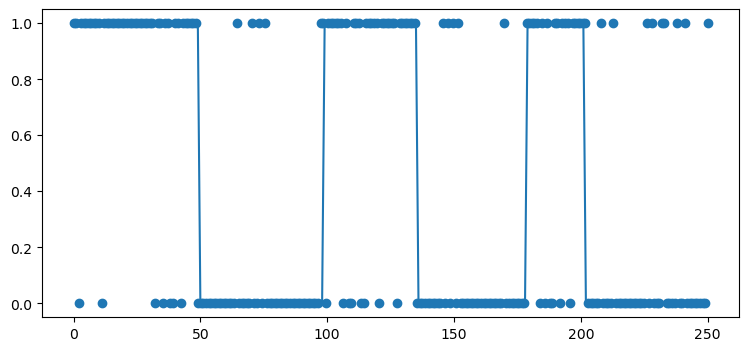

In [7]:
# an example sequence

stable_block_length = 50
volatile_block_length = 200 # no. of trials
block_number = 5
p_reward_volatile = 0.8 # probability of reward in stable block 
p_reward_stable = 0.8 # probability of reward in volatile block

stable_block, volatile_sequence = generate_reversal_sequence(stable_block_length, volatile_block_length, block_number)
stable_reward = generate_reward_sequence(stable_block, p_reward_stable)
volatile_reward = generate_reward_sequence(volatile_sequence, p_reward_volatile)

cue_sequence = np.append(stable_block, volatile_sequence)
reward_sequence = np.append(stable_reward, volatile_reward, axis=0)
plt.figure(figsize=(9,4))
plt.plot(cue_sequence)
plt.scatter(np.linspace(0,250,250), reward_sequence[:,1], label='rewards')
# example choices
choices =  simulate_choices_RW(stable_block_length+volatile_block_length, reward_sequence, alpha=0.6, beta=1)
plt.scatter(np.linspace(0,250, 250), choices, label='choices')
plt.legend()

In [ ]:
plt.plot(reward_sequence[:,0])

In [9]:
reward_sequence.shape

(250, 2)

In [ ]:
test_prediction, posterior_variance=predict_KF(250,reward_sequence,1,1,0.1,0.1)
plt.plot(test_prediction)

In [ ]:
# simulate choices based on rescorla wagner model

def simulate_choices_RW(N_trials, reward_sequence, alpha, beta):

    performance_run = []
    
    choices = np.full(N_trials, 0) # choices = 0 or 1
    
    model = RescorlaWagner(num_inputs=2, learning_rate=alpha, inv_temperature=beta)

    for i_trials in range(N_trials):

        choice = model.choice()
        rewards_arms = reward_sequence[i_trials, :]
        model.learn(choice, rewards_arms)
        choices[i_trials] = choice
    
    return choices

In [ ]:
# calculate likelihood

def calculate_likelihood_RW(params, choices, reward_sequence):
    
    alpha, beta = params

    likelihood = np.full( len(choices), 0.0)

    Q = np.full((2), 0.0) # num_inputs = 2

    for i_trials in range(len(choices)):

        choice = choices[i_trials]
        targets = reward_sequence[i_trials, :]
        Q_ = beta * Q
        logp_action = Q_ - sp.special.logsumexp(Q_)
        prob_choice = np.exp(logp_action)
        likelihood[i_trials] = prob_choice[choice]
        Q[choice] = Q[choice] + alpha * (targets[choice] - Q[choice])
            
    return -1*np.sum(np.log(likelihood+0.01))

In [ ]:
%%time
# example parameter recovery : grid search
choices = simulate_choices_RW(stable_block_length+volatile_block_length, reward_sequence, alpha=0.8, beta=1)

alpha_grid = np.linspace(0.01, 0.99, 30)
beta_grid = np.linspace(0.01, 10, 30)
negloglik_grid = np.full((30,30), 0.0)

for i_alpha, alpha in enumerate(alpha_grid):
    
    for i_beta, beta in enumerate(beta_grid):
        
        negloglik_grid[i_alpha, i_beta] = calculate_likelihood_RW((alpha, beta), choices, reward_sequence)
        
# sns.heatmap(negloglik_grid, xticklabels = np.round(beta_grid,2), yticklabels = np.round(alpha_grid, 2) )
idx = np.where(negloglik_grid == np.min(negloglik_grid))
print(alpha_grid[idx[0]])
print(beta_grid[idx[1]])

In [ ]:
%%time
# example parameter recovery : gradient descent
choices = simulate_choices_RW(stable_block_length+volatile_block_length, reward_sequence, alpha=0.8, beta=1)

res_nll = np.inf

for i in range(10):
        
    init_guess = ( np.random.uniform(0.0, 1.0),  np.random.exponential(1))
    result = sp.optimize.minimize( calculate_likelihood_RW, init_guess, (choices, reward_sequence), bounds=((0,1),(0.01,50)) )

    if result.fun < res_nll:
        res_nll = result.fun
        params_est = result.x
            
print(params_est)

In [ ]:
%%time
# param recovery with likelihood maximisation for a range of alpha and beta

stable_block_length = 50
volatile_block_length = 200 # no. of trials
block_number = 5
p_reward_volatile = 0.8 # probability of reward in stable block 
p_reward_stable = 0.8 # probability of reward in volatile block

N_iter = 200 # number of iterations of parameter recovery
params_estimated = np.full((N_iter, 2), 0.0)
params_true = np.full((N_iter,2), 0.0)

for i_param in range(N_iter):
    
        alpha_true = np.random.uniform(0.0, 1.0)
        beta_true = np.random.exponential(10) # exponential distribution for beta with lambda = 10 or scale = 0.1 following Wilson and Collins 2019
        
        # simulate task
        stable_block, volatile_sequence = generate_reversal_sequence(stable_block_length, volatile_block_length, block_number)
        stable_reward = generate_reward_sequence(stable_block, p_reward_stable)
        volatile_reward = generate_reward_sequence(volatile_sequence, p_reward_volatile)

        cue_sequence = np.append(stable_block, volatile_sequence)
        reward_sequence = np.append(stable_reward, volatile_reward, axis=0)
        
        # simulate choices
        choices = simulate_choices_RW(stable_block_length+volatile_block_length, reward_sequence, alpha_true, beta_true)
        
        res_nll = np.inf

        for i in range(10):

            init_guess = ( np.random.uniform(0.0, 1.0),  np.random.exponential(1))
            result = sp.optimize.minimize( calculate_likelihood_RW, init_guess, (choices, reward_sequence), bounds=((0,1),(0.01,20)) )

            if result.fun < res_nll:
                res_nll = result.fun
                params_est = result.x
        
        params_estimated[i_param, :] = params_est
        params_true[i_param, :] = [alpha_true, beta_true]


In [ ]:
#ax.set_prop_cycle('color',plt.cm.Blues(np.linspace(0.2,1,7)))
fig, ax = plt.subplots()

for i_alpha_true, alpha_true in enumerate(params_true[:,0]):
    
    ax.scatter(params_true[:,0], params_estimated[:,0], color ='tab:blue')
    ax.scatter(params_true[np.where(params_true[:,1] < 0.5),0], params_estimated[np.where(params_true[:,1] < 0.5),0], color ='tab:orange')
    ax.set_xlabel('True Alpha')
    ax.set_ylabel('Estimated Alpha')
    
#fig.legend(bbox_to_anchor =(1.2,0.5), loc='lower right')
plt.tight_layout()


fig, ax = plt.subplots()

for i_beta_true, beta_true in enumerate(params_true[:,1]):
    
    ax.scatter(params_true[:,1], params_estimated[:,1], color ='tab:blue')
    ax.set_xlabel('True Beta')
    ax.set_ylabel('Estimated Beta')
    
#fig.legend(bbox_to_anchor =(1.2,0.5), loc='lower right')
plt.tight_layout()